In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 49048280.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


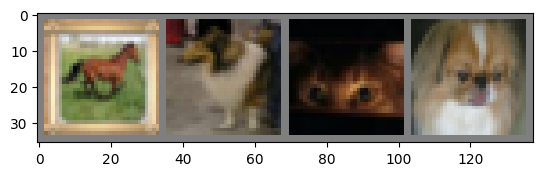

horse dog   cat   dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class LeNet(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 =  nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
model = LeNet(10).to(device)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
import copy

def train_model(model, train_data, optimizer, criterion, epochs=12, val_data=None, early_stopping=False, early_stopping_patience=5):
    """
        Reusable function to train a pytorch model.
        
        Input:
            model: PyTorch Model
            train_data: DataSet Loader with Train Data
            epochs: (default = 12) Number of epochs the model should be trained
            val_data: (Optional) DataSet Loader with Validation Data to perform the model on unseen data
            early_stopping: (default = False) Whether the training should stop early to avoid overfitting
            early_stopping_patience: (default = 5) Patience value for early stopping
            
        Returns:
            model: PyTorch model trained on the given data
            history: History of the values containing, Train loss, Train Accuracy, Val Loss and Val Accuracy (If validation data provided)
    
    """
    
    if val_data is None and early_stopping is True:
        raise ValueError("Early stopping is done based on the models performance on validation data, so inorder to perform early stopping, pass in validation data or set early_stopping = False")
    
    
    train_loader = train_data
    val_loader = val_data
    
    best_loss = float('inf')
    best_model_weights = None
    best_model_weights = copy.deepcopy(model.state_dict())
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []
    
    for epoch in range(epochs):
        
        model.train() # model in train mode
        
        train_losses = []
        train_correct = 0
        train_total = 0
        
        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = input_data
            x = x.to(device).float()
            y = y.to(device)

            output = model(x)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

            if batch_num % 500 == 0:
                print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))

        train_avg_loss = sum(train_losses) / len(train_losses)
        train_accuracy = 100 * train_correct / train_total
        print('Epoch %d | Training Loss %6.2f | Training Accuracy: %2.2f %%' % (epoch+1, train_avg_loss, train_accuracy))
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)

        if val_loader is not None:
            # Validation phase
            model.eval()
            
            val_losses = []
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_num, val_data in enumerate(val_loader):
                    x, y = val_data
                    x = x.to(device).float()
                    y = y.to(device)

                    val_output = model(x)
                    val_loss = criterion(val_output, y)
                    val_losses.append(val_loss.item())
                    _, val_predicted = torch.max(val_output.data, 1)
                    val_total += y.size(0)
                    val_correct += (val_predicted == y).sum().item()

            val_avg_loss = sum(val_losses) / len(val_losses)
            val_accuracy = 100 * val_correct / val_total
            print('Epoch %d | Validation Loss %6.2f | Validation Accuracy: %2.2f %%' % (epoch+1, val_avg_loss, val_accuracy))
            history['val_loss'].append(val_avg_loss)
            history['val_accuracy'].append(val_accuracy)

        if early_stopping is not False:
            # Early stopping
            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here 
                patience = early_stopping_patience  # Reset patience counter
                print(f"Saving the best model at {epoch+1}th epoch.")
            else:
                patience -= 1
                if patience == 0:
                    print(f"Stopping the training")
                    break

    # Load the best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history

In [ ]:
model, history = train_model(model, trainloader, optimizer, criterion, 12, val_data = testloader, early_stopping = True, 3)

In [33]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [34]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 39 %
